# CLASSIFICATION

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')

from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score

from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

Using TensorFlow backend.
C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Preparation

In [2]:
# crea un dataset di 6 ore
def build_dataset(df, attribute, class_name):
    X = []
    y = []
    for d in [3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17]:
        day = df.loc[df['day'] == d]
        for h in range(0, 4):
            if h != 0:
                hour = day.loc[(day['hour'] >= h * 6) & (day['hour'] < (h+1) * 6)]
            else:
                hour = day.loc[day['hour'] <= 5]
            X.append(hour[attribute].values)
            y.append(1 if hour[class_name].mean() >= 0.50 else 0)
    X = np.array(X)
    y = np.array(y)
    return X, y

C:\Users\dalla\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


(48, 360)
[0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 1 0]


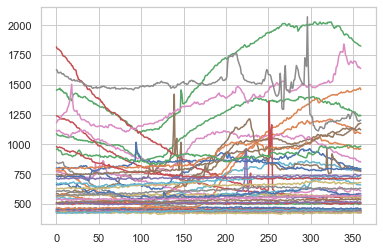

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')

df = pd.read_csv('dataset.csv', parse_dates= True, index_col='date', date_parser=dateparse)

X, y = build_dataset(df, 'CO2', 'Occupancy')
print(X.shape)
print(y)

for i in range(len(X)):
    plt.plot(X[i])
plt.show()

In [4]:
len(X[0])

360

# Data Normalization

# Data Partitioning

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

print(X_train.shape)
print(X_test.shape)

(33, 360)
(15, 360)


# Shaplet Classifier

In [6]:
n_ts, ts_sz = X_train.shape
n_classes = 2
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.3,
                                                       r=2)
print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer='adam',
                        weight_regularizer=0.01,
                        max_iter=1000,
                        random_state=0)
shp_clf.fit(X_train, y_train)
y_pred = shp_clf.predict(X_test)
predicted_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(y_test)
print(y_pred)

n_ts 33
ts_sz 360
n_classes 2
shapelet_sizes {108: 3, 216: 3}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Correct classification rate: 0.9333333333333333
Accuracy 0.9333333333333333
F1-score [0.95652174 0.85714286]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.75      0.86         4

    accuracy                           0.93        15
   macro avg       0.96      0.88      0.91        15
weighted avg       0.94      0.93      0.93        15

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]


C:\Users\dalla\Anaconda3\lib\site-packages\tslearn\utils.py:63: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


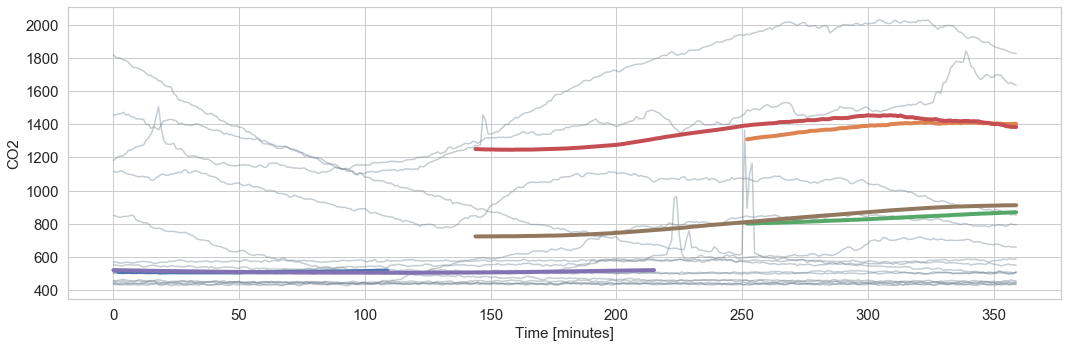

In [22]:
predicted_locations = shp_clf.locate(X_train)
ts_id = 0
n_shapelets = sum(shapelet_sizes.values())

plt.figure(figsize=(15, 5))

for i in range(len(X_test)):
    plt.plot(X_test[i], color='slategrey', alpha= 0.4)

for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=4)


plt.xlabel("Time [minutes]", fontsize = 15)
plt.ylabel("CO2", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

# Shaplet-distances-based Classifier

In [ ]:
X_train2 = shp_clf.transform(X_train)

In [ ]:
X_train2.shape

In [ ]:
X_train2

In [ ]:
X_test2 = shp_clf.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train2, y_train)

In [ ]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# Feature-based Classifier

In [165]:
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [166]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [169]:
X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

In [170]:
len(X_train3)

33

In [171]:
len(X_test3)

15

In [191]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(y_test)
print(y_pred)

Accuracy 0.7333333333333333
F1-score [0.83333333 0.33333333]
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.50      0.25      0.33         4

    accuracy                           0.73        15
   macro avg       0.63      0.58      0.58        15
weighted avg       0.70      0.73      0.70        15

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [193]:
from sklearn.model_selection import GridSearchCV

param_list = {'min_samples_split': [_ for _ in range(1, 10, 5)],
              'min_samples_leaf': [_ for _ in range(1, 10, 5)],
              'max_depth': [_ for _ in range(1, 5)]
             }

grid_search = GridSearchCV(clf, param_grid=param_list, cv=5)
grid_search.fit(X_train3, y_train)
clf = grid_search.best_estimator_

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print(y_test)
print(y_pred)
print(clf)

Accuracy 0.8666666666666667
F1-score [0.90909091 0.75      ]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.75      0.75      0.75         4

    accuracy                           0.87        15
   macro avg       0.83      0.83      0.83        15
weighted avg       0.87      0.87      0.87        15

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0]
[1 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


D:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
D:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
D:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

# Time Series Classifier

In [177]:
from pyts.classification import KNeighborsClassifier
parameters = {'n_neighbors': np.arange(1, 10 + 1), 
              'weights': ['uniform', 'distance'],
             'metric' : ['dtw_sakoechiba']}
 
knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters)
search.fit(X_train3, y_train)
search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='dtw_sakoechiba',
                     metric_params=None, n_jobs=1, n_neighbors=3, p=2,
                     weights='distance')

In [178]:
clf = search.best_estimator_

clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(y_test)
print(y_pred)
print(clf)

Accuracy 0.7333333333333333
F1-score [0.8 0.6]
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.50      0.75      0.60         4

    accuracy                           0.73        15
   macro avg       0.69      0.74      0.70        15
weighted avg       0.79      0.73      0.75        15

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0]
[1 1 1 0 1 0 0 1 1 0 0 0 0 0 0]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='dtw_sakoechiba',
                     metric_params=None, n_jobs=1, n_neighbors=3, p=2,
                     weights='distance')


In [88]:
from pyts.classification import KNeighborsClassifier

In [187]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba', weights = 'distance', n_neighbors = 2)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(y_test)
print(y_pred)
print(clf)

Accuracy 0.8666666666666667
F1-score [0.9 0.8]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.67      1.00      0.80         4

    accuracy                           0.87        15
   macro avg       0.83      0.91      0.85        15
weighted avg       0.91      0.87      0.87        15

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0]
[1 1 1 0 1 0 0 0 1 0 0 0 0 1 0]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='dtw_sakoechiba',
                     metric_params=None, n_jobs=1, n_neighbors=2, p=2,
                     weights='distance')


# CNN Classifier

In [194]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [207]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
#    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
    
#    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

cnn = build_simple_cnn(n_timesteps, n_outputs)

cnn.summary()

rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.01)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(y_test)
print(y_pred)

cnn.evaluate(X_test_cnn, y_test)

TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_40 (Batc (None, 353, 16)           64        
_________________________________________________________________
activation_13 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 353, 16)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_41 (Batc (None, 351, 64)           256       
_________________________________________________________________
activation_14 (Activation)   (None, 351, 64)  

[0.6754416823387146, 0.9333333373069763]

In [233]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int or None, optional (default=None)
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_s

In [236]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
#    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
    
#    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
for i in range(100):
    print('============================================', i, '=============================================================')
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train, random_state = i)

    n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
    print("TIMESTEPS: ", n_timesteps)
    print("N. LABELS: ", n_outputs)

    cnn = build_simple_cnn(n_timesteps, n_outputs)

    cnn.summary()

    rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.01)
    mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

    callbacks = [rlr, mc]

    batch_size = 16
    mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

    history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

    y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))
    print(y_test)
    print(y_pred)

    cnn.evaluate(X_test_cnn, y_test)

============================================ 0 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_53 (Batc (None, 353, 16)           64        
_________________________________________________________________
activation_26 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 353, 16)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_54 (Batc (None, 351, 64)           256       
___

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 16s 626ms/step - loss: 0.7356 - acc: 0.5000 - val_loss: 0.6958 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 0s 15ms/step - loss: 0.7099 - acc: 0.5769 - val_loss: 0.6834 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 0s 14ms/step - loss: 0.6933 - acc: 0.6154 - val_loss: 0.6776 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 0s 15ms/step - loss: 0.6808 - acc: 0.6923 - val_loss: 0.6950 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 0s 15ms/step - loss: 0.6814 - acc: 0.5000 - val_loss: 0.6991 - val_acc: 0.4286
Accuracy 0.13333333333333333
F1-score [0.13333333 0.13333333]
              precision    recall  f1-score   support

           0       0.25      0.09      0.13        11
           1       0.09      0.25      0.13         4

    accuracy                           0.13        15
   macro avg       0.17  

Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 18s 694ms/step - loss: 0.6858 - acc: 0.6538 - val_loss: 0.6548 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 0s 15ms/step - loss: 0.6808 - acc: 0.7308 - val_loss: 0.6407 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 0.6594 - acc: 0.7308 - val_loss: 0.6600 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6389 - acc: 0.7308 - val_loss: 0.7376 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 0s 13ms/step - loss: 0.6348 - acc: 0.7308 - val_loss: 0.7346 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42         4

    accuracy                           0.27        15
   macro avg       0.13  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_65 (Batc (None, 353, 16)           64        
_________________________________________________________________
activation_38 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 353, 16)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_66 (Batc (None, 351, 64)           256       
_________________________________________________________________
activation_39 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 20s 773ms/step - loss: 0.6205 - acc: 0.7308 - val_loss: 4.3206 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 0.7062 - acc: 0.7308 - val_loss: 2.8367 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 0.7290 - acc: 0.7308 - val_loss: 0.8075 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6665 - acc: 0.7308 - val_loss: 0.6928 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6529 - acc: 0.7308 - val_loss: 0.9082 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37   

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 22s 838ms/step - loss: 0.7162 - acc: 0.6538 - val_loss: 1.0145 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 0.6695 - acc: 0.7308 - val_loss: 0.9041 - val_acc: 0.2857
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 0.6641 - acc: 0.7692 - val_loss: 1.3293 - val_acc: 0.2857
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 0.6427 - acc: 0.7308 - val_loss: 1.1410 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 1s 20ms/step - loss: 0.6309 - acc: 0.6538 - val_loss: 0.7208 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42         4

    accuracy                           0.27        15
   macro avg       0.13  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 22s 829ms/step - loss: 0.6901 - acc: 0.6538 - val_loss: 0.7044 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - ETA: 0s - loss: 0.6889 - acc: 0.681 - 0s 17ms/step - loss: 0.6769 - acc: 0.7308 - val_loss: 0.6724 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 0s 15ms/step - loss: 0.6649 - acc: 0.7308 - val_loss: 0.6737 - val_acc: 0.8571
Epoch 4/5
26/26 [==============================] - 0s 15ms/step - loss: 0.6496 - acc: 0.7308 - val_loss: 0.7767 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 0s 16ms/step - loss: 0.6259 - acc: 0.7308 - val_loss: 0.7459 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


conv1d_49 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_76 (Batc (None, 351, 64)           256       
_________________________________________________________________
activation_49 (Activation)   (None, 351, 64)           0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 351, 64)           0         
_________________________________________________________________
global_average_pooling1d_23  (None, 64)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 22s 848ms/step - loss: 0.6932 - acc: 0.6923 

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 23s 903ms/step - loss: 0.6706 - acc: 0.7308 - val_loss: 0.9681 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6626 - acc: 0.7308 - val_loss: 0.7915 - val_acc: 0.2857
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6325 - acc: 0.7308 - val_loss: 0.7941 - val_acc: 0.2857
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 0.6288 - acc: 0.7308 - val_loss: 0.8262 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 0s 18ms/step - loss: 0.6211 - acc: 0.7308 - val_loss: 0.7674 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42         4

    accuracy                           0.27        15
   macro avg       0.13  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_79 (Batc (None, 353, 16)           64        
_________________________________________________________________
activation_52 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_80 (Batc (None, 351, 64)           256       
_________________________________________________________________
activation_53 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



activation_55 (Activation)   (None, 351, 64)           0         
_________________________________________________________________
dropout_116 (Dropout)        (None, 351, 64)           0         
_________________________________________________________________
global_average_pooling1d_26  (None, 64)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 27s 1s/step - loss: 0.7293 - acc: 0.6923 - val_loss: 0.7451 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 21ms/step - loss: 0.6765 - acc: 0.7308 - val_loss: 0.6436 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 21ms/step - loss: 0.6483 - acc: 0.7308 - val_

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_83 (Batc (None, 353, 16)           64        
_________________________________________________________________
activation_56 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_84 (Batc (None, 351, 64)           256       
_________________________________________________________________
activation_57 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 25s 968ms/step - loss: 0.6740 - acc: 0.7308 - val_loss: 1.1811 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6494 - acc: 0.7308 - val_loss: 1.2604 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 0.6565 - acc: 0.7308 - val_loss: 1.1280 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6277 - acc: 0.7308 - val_loss: 1.1290 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 0s 19ms/step - loss: 0.6009 - acc: 0.7308 - val_loss: 1.0772 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37   

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


activation_61 (Activation)   (None, 351, 64)           0         
_________________________________________________________________
dropout_122 (Dropout)        (None, 351, 64)           0         
_________________________________________________________________
global_average_pooling1d_29  (None, 64)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 26s 997ms/step - loss: 0.8062 - acc: 0.6154 - val_loss: 2.7709 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 20ms/step - loss: 0.7314 - acc: 0.5769 - val_loss: 1.0039 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 20ms/step - loss: 0.6453 - acc: 0.7308 - va

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 27s 1s/step - loss: 0.7026 - acc: 0.5769 - val_loss: 0.5827 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6752 - acc: 0.7308 - val_loss: 0.6330 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 0.6548 - acc: 0.7308 - val_loss: 0.6281 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 21ms/step - loss: 0.6118 - acc: 0.7308 - val_loss: 0.6515 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 20ms/step - loss: 0.5982 - acc: 0.7308 - val_loss: 0.6542 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_91 (Batc (None, 353, 16)           64        
_________________________________________________________________
activation_64 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_125 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_92 (Batc (None, 351, 64)           256       
_________________________________________________________________
activation_65 (Activation)   (None, 351, 64)           0         
_________________________________________________________________
dropout_1

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 28s 1s/step - loss: 0.7594 - acc: 0.4615 - val_loss: 0.7855 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 0.6804 - acc: 0.6154 - val_loss: 1.0593 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 20ms/step - loss: 0.6643 - acc: 0.7308 - val_loss: 1.3786 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 20ms/step - loss: 0.6380 - acc: 0.7308 - val_loss: 1.2665 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 0s 19ms/step - loss: 0.6554 - acc: 0.7308 - val_loss: 1.0336 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 29s 1s/step - loss: 0.7159 - acc: 0.5000 - val_loss: 1.0117 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 0.6686 - acc: 0.7308 - val_loss: 2.4345 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 0.6517 - acc: 0.7308 - val_loss: 1.7807 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 0.6435 - acc: 0.7308 - val_loss: 1.8559 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 0s 19ms/step - loss: 0.6360 - acc: 0.7308 - val_loss: 1.9081 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_97 (Batc (None, 353, 16)           64        
_________________________________________________________________
activation_70 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_131 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_98 (Batc (None, 351, 64)           256       
_________________________________________________________________
activation_71 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


global_average_pooling1d_35  (None, 64)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 32s 1s/step - loss: 0.7078 - acc: 0.5385 - val_loss: 3.0424 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 21ms/step - loss: 0.6853 - acc: 0.6538 - val_loss: 2.5445 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 23ms/step - loss: 0.7055 - acc: 0.6538 - val_loss: 1.7003 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 23ms/step - loss: 0.7079 - acc: 0.6538 - val_loss: 1.0682 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 22ms/step - loss: 0.6937 - acc: 0.7308 - val_loss:

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_101 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_74 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_135 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_102 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_75 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_103 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_76 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_137 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_104 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_77 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


conv1d_78 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_105 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_78 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_139 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_106 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_79 (Activation)   (None, 351, 64)           0         
_________________________________________________________________
dropout_140 (Dropout)        (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 33s 1s/step - loss: 0.7261 - acc: 0.5000 - val_loss: 1.0104 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 22ms/step - loss: 0.7124 - acc: 0.6538 - val_loss: 0.6012 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 20ms/step - loss: 0.6738 - acc: 0.6923 - val_loss: 0.6827 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 20ms/step - loss: 0.6276 - acc: 0.6923 - val_loss: 0.7114 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 1s 19ms/step - loss: 0.5971 - acc: 0.6538 - val_loss: 0.7063 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42         4

    accuracy                           0.27        15
   macro avg       0.13     

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 35s 1s/step - loss: 0.6762 - acc: 0.6923 - val_loss: 0.9412 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 21ms/step - loss: 0.6320 - acc: 0.7308 - val_loss: 0.7204 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 22ms/step - loss: 0.6383 - acc: 0.7308 - val_loss: 0.6818 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6349 - acc: 0.7308 - val_loss: 0.6935 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 23ms/step - loss: 0.5982 - acc: 0.7308 - val_loss: 1.6845 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42         4

    accuracy                           0.27        15
   macro avg       0.13     

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 37s 1s/step - loss: 0.7043 - acc: 0.6538 - val_loss: 0.9948 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 22ms/step - loss: 0.6421 - acc: 0.6538 - val_loss: 0.6860 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6485 - acc: 0.6923 - val_loss: 0.6773 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 24ms/step - loss: 0.6131 - acc: 0.6923 - val_loss: 0.6706 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 25ms/step - loss: 0.5618 - acc: 0.6538 - val_loss: 0.6617 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 36s 1s/step - loss: 0.7159 - acc: 0.5769 - val_loss: 2.2700 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 25ms/step - loss: 0.6837 - acc: 0.6923 - val_loss: 0.7824 - val_acc: 0.2857
Epoch 3/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6773 - acc: 0.6923 - val_loss: 0.6712 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 21ms/step - loss: 0.6446 - acc: 0.7308 - val_loss: 0.6973 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 21ms/step - loss: 0.6378 - acc: 0.7308 - val_loss: 0.7008 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_115 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_88 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_149 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_116 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_89 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 38s 1s/step - loss: 0.7501 - acc: 0.6154 - val_loss: 0.7543 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 23ms/step - loss: 0.7629 - acc: 0.3846 - val_loss: 0.6481 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 27ms/step - loss: 0.6796 - acc: 0.6923 - val_loss: 0.6113 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 24ms/step - loss: 0.6784 - acc: 0.6923 - val_loss: 0.6169 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 25ms/step - loss: 0.6605 - acc: 0.7308 - val_loss: 0.6156 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 39s 1s/step - loss: 0.7632 - acc: 0.5000 - val_loss: 0.6990 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6872 - acc: 0.6923 - val_loss: 0.9328 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 22ms/step - loss: 0.6604 - acc: 0.6154 - val_loss: 1.2114 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 22ms/step - loss: 0.6670 - acc: 0.7308 - val_loss: 1.5279 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 25ms/step - loss: 0.6263 - acc: 0.7308 - val_loss: 1.4169 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 40s 2s/step - loss: 0.7043 - acc: 0.5769 - val_loss: 0.5958 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6853 - acc: 0.7692 - val_loss: 0.6107 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 26ms/step - loss: 0.6804 - acc: 0.7308 - val_loss: 0.6128 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6546 - acc: 0.6538 - val_loss: 0.6801 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 27ms/step - loss: 0.6271 - acc: 0.7308 - val_loss: 0.6286 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_123 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_96 (Activation)   (None, 353, 16)           0         
_________________________________________________________________
dropout_157 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_124 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_97 (Activation)   (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 43s 2s/step - loss: 0.7061 - acc: 0.7308 - val_loss: 0.7181 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 28ms/step - loss: 0.6816 - acc: 0.7308 - val_loss: 3.1154 - val_acc: 0.2857
Epoch 3/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6446 - acc: 0.6923 - val_loss: 3.3250 - val_acc: 0.2857
Epoch 4/5
26/26 [==============================] - 1s 23ms/step - loss: 0.6061 - acc: 0.7692 - val_loss: 3.5793 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 1s 28ms/step - loss: 0.5906 - acc: 0.6923 - val_loss: 3.1044 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42         4

    accuracy                           0.27        15
   macro avg       0.13     

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 43s 2s/step - loss: 0.6691 - acc: 0.6154 - val_loss: 0.6394 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 24ms/step - loss: 0.6405 - acc: 0.7308 - val_loss: 0.6256 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 26ms/step - loss: 0.6596 - acc: 0.7308 - val_loss: 0.6338 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 29ms/step - loss: 0.6338 - acc: 0.7308 - val_loss: 0.6350 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 25ms/step - loss: 0.6006 - acc: 0.7308 - val_loss: 0.6356 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 47s 2s/step - loss: 0.6982 - acc: 0.5000 - val_loss: 0.6093 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 26ms/step - loss: 0.6680 - acc: 0.7308 - val_loss: 0.9343 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 25ms/step - loss: 0.7057 - acc: 0.6538 - val_loss: 0.6254 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 28ms/step - loss: 0.7043 - acc: 0.7308 - val_loss: 0.7129 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 1s 28ms/step - loss: 0.6412 - acc: 0.6154 - val_loss: 0.7172 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42         4

    accuracy                           0.27        15
   macro avg       0.13     

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 39 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_104 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_131 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_104 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_165 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_132 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


batch_normalization_134 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_107 (Activation)  (None, 351, 64)           0         
_________________________________________________________________
dropout_168 (Dropout)        (None, 351, 64)           0         
_________________________________________________________________
global_average_pooling1d_52  (None, 64)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 46s 2s/step - loss: 0.7736 - acc: 0.5385 - val_loss: 0.7203 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 29ms/step - loss: 0.7071 - acc: 0.5769 - val

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 48s 2s/step - loss: 0.6956 - acc: 0.6923 - val_loss: 0.6654 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 28ms/step - loss: 0.6399 - acc: 0.7308 - val_loss: 1.1430 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 28ms/step - loss: 0.6741 - acc: 0.7308 - val_loss: 0.7626 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 31ms/step - loss: 0.6448 - acc: 0.7308 - val_loss: 0.6716 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 28ms/step - loss: 0.6529 - acc: 0.7308 - val_loss: 0.6612 - val_acc: 0.7143
Accuracy 0.8666666666666667
F1-score [0.90909091 0.75      ]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.75      0.75      0.75         4

    accuracy                           0.87        15
   macro avg       0.83      

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_112 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_139 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_112 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_173 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_140 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_113 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_141 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_114 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_175 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_142 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_115 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


conv1d_117 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_144 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_117 (Activation)  (None, 351, 64)           0         
_________________________________________________________________
dropout_178 (Dropout)        (None, 351, 64)           0         
_________________________________________________________________
global_average_pooling1d_57  (None, 64)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 51s 2s/step - loss: 0.7212 - acc: 0.7308 - v

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 52s 2s/step - loss: 0.7942 - acc: 0.6154 - val_loss: 1.1528 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 29ms/step - loss: 0.7138 - acc: 0.6923 - val_loss: 0.6440 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 34ms/step - loss: 0.6967 - acc: 0.7308 - val_loss: 0.6452 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 29ms/step - loss: 0.6817 - acc: 0.6154 - val_loss: 0.6585 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 26ms/step - loss: 0.6800 - acc: 0.6538 - val_loss: 0.6542 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 53s 2s/step - loss: 0.6958 - acc: 0.4615 - val_loss: 2.5609 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 29ms/step - loss: 0.6670 - acc: 0.7308 - val_loss: 1.0588 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 35ms/step - loss: 0.6686 - acc: 0.7308 - val_loss: 0.7025 - val_acc: 0.2857
Epoch 4/5
26/26 [==============================] - 1s 30ms/step - loss: 0.6506 - acc: 0.7308 - val_loss: 1.0234 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 1s 33ms/step - loss: 0.6328 - acc: 0.7308 - val_loss: 0.8913 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42 

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_122 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_149 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_122 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_183 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_150 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_123 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 57s 2s/step - loss: 0.7005 - acc: 0.6538 - val_loss: 0.6452 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 29ms/step - loss: 0.6499 - acc: 0.7308 - val_loss: 0.6923 - val_acc: 0.2857
Epoch 3/5
26/26 [==============================] - 1s 31ms/step - loss: 0.6099 - acc: 0.6923 - val_loss: 0.6612 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 33ms/step - loss: 0.6056 - acc: 0.7308 - val_loss: 0.6639 - val_acc: 0.8571
Epoch 5/5
26/26 [==============================] - 1s 30ms/step - loss: 0.5300 - acc: 0.8462 - val_loss: 0.6708 - val_acc: 0.8571
Accuracy 0.4666666666666667
F1-score [0.42857143 0.5       ]
              precision    recall  f1-score   support

           0       1.00      0.27      0.43        11
           1       0.

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_130 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_157 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_130 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_191 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_158 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_131 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_159 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_132 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_193 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_160 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_133 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 61s 2s/step - loss: 0.7242 - acc: 0.5769 - val_loss: 1.8327 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 33ms/step - loss: 0.7078 - acc: 0.6154 - val_loss: 0.9098 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 33ms/step - loss: 0.6920 - acc: 0.7308 - val_loss: 0.8043 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 37ms/step - loss: 0.6892 - acc: 0.6154 - val_loss: 0.6540 - val_acc: 0.7143
Epoch 5/5
26/26 [==============================] - 1s 32ms/step - loss: 0.6581 - acc: 0.8077 - val_loss: 0.6721 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_163 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_136 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_197 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_164 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_137 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_138 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_165 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_138 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_199 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_166 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_139 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_167 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_140 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_201 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_168 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_141 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dense_123 (Dense)            (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 66s 3s/step - loss: 0.6990 - acc: 0.3077 - val_loss: 1.2568 - val_acc: 0.7143
Epoch 2/5
26/26 [==============================] - 1s 33ms/step - loss: 0.6890 - acc: 0.6154 - val_loss: 1.4545 - val_acc: 0.7143
Epoch 3/5
26/26 [==============================] - 1s 36ms/step - loss: 0.7093 - acc: 0.7308 - val_loss: 0.6850 - val_acc: 0.7143
Epoch 4/5
26/26 [==============================] - 1s 36ms/step - loss: 0.6701 - acc: 0.7308 - val_loss: 0.7593 - val_acc: 0.2857
Epoch 5/5
26/26 [==============================] - 1s 35ms/step - loss: 0.6912 - acc: 0.7308 - val_loss: 0.8041 - val_acc: 0.2857
Accuracy 0.26666666666666666
F1-score [0.         0.42105263]
              precision    recall  f1-score 

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_144 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_171 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_144 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_205 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_145 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_172 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_145 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_146 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_173 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_146 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_207 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_174 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_147 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_148 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_175 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_148 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_209 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_176 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_149 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_177 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_150 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_211 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_178 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_151 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_152 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_179 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_152 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_213 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_180 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_153 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_154 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_181 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_154 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_215 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_182 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_155 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_183 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_156 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_217 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_184 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_157 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



batch_normalization_186 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_159 (Activation)  (None, 351, 64)           0         
_________________________________________________________________
dropout_220 (Dropout)        (None, 351, 64)           0         
_________________________________________________________________
global_average_pooling1d_78  (None, 64)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 2)                 130       
Total params: 3,730
Trainable params: 3,570
Non-trainable params: 160
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/5
26/26 [==============================] - 86s 3s/step - loss: 0.6899 - acc: 0.6538 - val_loss: 2.0375 - val_acc: 0.2857
Epoch 2/5
26/26 [==============================] - 1s 45ms/step - loss: 0.6874 - acc: 0.5769 - va

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_160 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_187 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_160 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_221 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_188 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_161 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_189 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_162 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_223 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_190 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_163 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_164 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_191 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_164 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_225 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_192 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_165 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_166 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_193 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_166 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_227 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_194 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_167 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_168 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_195 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_168 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_229 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_196 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_169 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_172 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_199 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_172 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_233 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_200 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_173 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_174 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_201 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_174 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_235 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_202 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_175 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_176 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_203 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_176 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_237 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_204 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_177 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_178 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_205 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_178 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_239 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_206 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_179 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_209 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_182 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_243 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_210 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_183 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_184 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_211 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_184 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_245 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_212 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_185 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_186 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_213 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_186 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_247 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_214 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_187 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_188 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_215 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_188 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_249 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_216 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_189 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_190 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_217 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_190 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_251 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_218 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_191 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_192 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_219 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_192 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_253 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_220 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_193 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_194 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_221 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_194 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_255 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_222 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_195 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_198 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_225 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_198 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_259 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_226 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_199 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_200 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_227 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_200 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_261 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_228 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_201 (Activation)  (None, 351, 64)           0         
__________

Epoch 5/5
26/26 [==============================] - 1s 55ms/step - loss: 0.5873 - acc: 0.6154 - val_loss: 0.7027 - val_acc: 0.7143
Accuracy 0.7333333333333333
F1-score [0.84615385 0.        ]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15/15 [==============================] - 0s 6ms/step
============================================ 90 =============================================================
TIMESTEPS:  360
N. LABELS:  2


D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_233 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_206 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_267 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_234 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_207 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_208 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_235 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_208 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_269 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_236 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_209 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_210 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_237 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_210 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_271 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_238 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_211 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_212 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_239 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_212 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_273 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_240 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_213 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_216 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_243 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_216 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_277 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_244 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_217 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_218 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_245 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_218 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_279 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_246 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_219 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_220 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_247 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_220 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_281 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_248 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_221 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_222 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_249 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_222 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_283 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_250 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_223 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_224 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_251 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_224 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_285 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_252 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_225 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [271]:
def build_simple_cnn(n_timesteps, n_outputs, i):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
#    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
    
#    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) #Conv1D non ha random state
    model.add(BatchNormalization()) #BatchNormalization non ha random state
    model.add(Activation('relu')) #non ha random state
    
    model.add(Dropout(0.3, seed = i)) #EUREKA!!!!
    
    model.add(GlobalAveragePooling1D()) #non ha random state
    
    model.add(Dense(n_outputs, activation='sigmoid')) #Dense non ha random state
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #.compile non ha random state
    
    return model


for i in range(100):
    print('============================================', i, '=============================================================')
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) #reshape non ha random state
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train, random_state = 76)

    n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
    print("TIMESTEPS: ", n_timesteps)
    print("N. LABELS: ", n_outputs)

    cnn = build_simple_cnn(n_timesteps, n_outputs, i)

    cnn.summary()

    rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.01) #Non ha random state

    mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True) #Non ha random state


    callbacks = [rlr, mc]

    batch_size = 16
    mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

    history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history #.fit non ha random state

    y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))
    print(y_test)
    print(y_pred)

    cnn.evaluate(X_test_cnn, y_test)

============================================ 0 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_250 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_278 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_250 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_311 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_251 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_279 (Bat (None, 351, 64)           256       
___

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_252 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_280 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_252 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_313 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_281 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_253 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_254 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_282 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_254 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_315 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_283 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_255 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_256 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_284 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_256 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_317 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_257 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_285 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_257 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_258 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_286 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_258 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_319 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_259 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_287 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_259 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_260 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_288 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_260 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_321 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_289 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_261 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_262 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_290 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_262 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_323 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_291 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_263 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_264 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_292 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_264 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_325 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_293 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_265 (Activation)  (None, 351, 64)  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_294 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_266 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_327 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_295 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_267 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_268 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_296 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_268 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_329 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_297 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_269 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_270 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_298 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_270 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_331 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_271 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_299 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_271 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_274 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_302 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_274 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_335 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_303 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_275 (Activation)  (None, 351, 64)           0         
__________

26/26 [==============================] - 2s 66ms/step - loss: 0.6427 - acc: 0.7308 - val_loss: 0.6724 - val_acc: 0.8571
Accuracy 0.9333333333333333
F1-score [0.95652174 0.85714286]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.75      0.86         4

    accuracy                           0.93        15
   macro avg       0.96      0.88      0.91        15
weighted avg       0.94      0.93      0.93        15

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
15/15 [==============================] - 0s 11ms/step
============================================ 15 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_280 (Conv1D)          (None, 353, 16)           144       
____________________________________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_282 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_310 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_282 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_343 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_283 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_311 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_283 (Activation)  (None, 351, 64)  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_284 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_312 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_284 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_345 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_285 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_313 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_285 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_314 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_286 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_347 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_315 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_287 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_288 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_316 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_288 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_349 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_317 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_289 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 21 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_292 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_320 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_292 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_353 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_321 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 22 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_294 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_322 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_294 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_355 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_323 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 23 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_296 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_324 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_296 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_357 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_297 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_325 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 24 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_298 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_326 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_298 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_359 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_299 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_327 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_328 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_300 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_361 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_329 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_301 (Activation)  (None, 351, 64)  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_302 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_330 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_302 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_363 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_303 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_331 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_303 (Activation)  (None, 351, 64)  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_304 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_332 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_304 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_365 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_305 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_333 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_305 (Activation)  (None, 351, 64)           0         
__________

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 28 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_306 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_334 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_306 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_367 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_307 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 14ms/step
============================================ 29 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_336 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_308 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_369 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 31 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_312 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_340 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_312 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_373 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_313 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_341 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_316 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_344 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_316 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_377 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_317 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_345 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_317 (Activation)  (None, 351, 64) 

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_318 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_346 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_318 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_379 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_319 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_347 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_319 (Activation)  (None, 351, 64)           0 

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 17ms/step
============================================ 35 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_320 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_348 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_320 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_381 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_321 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_322 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_350 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_322 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_383 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_323 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_351 (Bat (None, 351, 64)           256       
_________________________________________________________________
activation_323 (Activation)  (None, 351, 64)  

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 13ms/step
============================================ 37 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_324 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_352 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_324 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_385 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_325 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 39 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_328 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_356 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_328 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_389 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_329 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_357 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 40 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_330 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_358 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_330 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_391 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_331 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_359 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 13ms/step
============================================ 41 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_360 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_332 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_393 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 42 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_334 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_362 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_334 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_395 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_335 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_363 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 44 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_338 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_366 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_338 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_399 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_367 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 45 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_340 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_368 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_340 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_401 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_341 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_369 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 46 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_342 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_370 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_342 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_403 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_343 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_371 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 47 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_344 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_372 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_344 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_405 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_345 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 48 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_346 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_374 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_346 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_407 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_347 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_375 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 14ms/step
============================================ 49 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_348 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_376 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_348 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_409 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_349 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 50 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_350 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_378 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_350 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_411 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_351 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_379 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 14ms/step
============================================ 51 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_352 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_380 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_352 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_413 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_353 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 52 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_354 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_382 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_354 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_415 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_383 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 14ms/step
============================================ 53 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_356 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_384 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_356 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_417 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_357 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 13ms/step
============================================ 55 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_360 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_388 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_360 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_421 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_361 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 14ms/step
============================================ 56 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_362 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_390 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_362 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_423 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_363 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 57 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_364 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_392 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_364 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_425 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 58 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_366 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_394 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_366 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_427 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_367 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_395 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 59 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_368 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_396 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_368 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_429 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_369 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 60 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_370 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_398 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_370 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_431 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_371 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


============================================ 61 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_372 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_400 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_372 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_433 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_373 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_401 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 62 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_374 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_402 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_374 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_435 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_375 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 63 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_376 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_404 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_376 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_437 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_377 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step
============================================ 68 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_386 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_414 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_386 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_447 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_387 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step
============================================ 69 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_388 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_416 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_388 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_449 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_389 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 70 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_390 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_418 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_390 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_451 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_391 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step
============================================ 71 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_392 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_420 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_392 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_453 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_393 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 14ms/step
============================================ 72 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_394 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_422 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_394 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_455 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_395 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 73 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_396 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_424 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_396 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_457 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_397 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step
============================================ 74 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_398 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_426 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_398 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_459 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_399 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step
============================================ 75 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_400 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_428 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_400 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_461 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_401 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step
============================================ 76 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_402 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_430 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_402 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_463 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_403 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 15ms/step
============================================ 78 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_406 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_434 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_406 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_467 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_407 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 17ms/step
============================================ 79 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_408 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_436 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_408 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_469 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_409 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 17ms/step
============================================ 80 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_410 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_438 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_410 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_471 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_411 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 81 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_412 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_440 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_412 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_473 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_413 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 83 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_416 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_444 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_416 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_477 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_417 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 16ms/step
============================================ 84 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_418 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_446 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_418 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_479 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_419 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 85 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_420 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_448 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_420 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_481 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 20ms/step
============================================ 86 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_422 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_450 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_422 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_483 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_423 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step
============================================ 87 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_424 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_452 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_424 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_485 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_425 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 88 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_426 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_454 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_426 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_487 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_427 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 17ms/step
============================================ 89 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_428 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_456 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_428 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_489 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_429 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step
============================================ 91 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_432 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_460 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_432 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_493 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_433 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 92 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_434 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_462 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_434 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_495 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_435 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 93 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_436 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_464 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_436 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_497 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_437 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step
============================================ 94 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_438 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_466 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_438 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_499 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_439 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 20ms/step
============================================ 95 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_440 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_468 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_440 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_501 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_441 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step
============================================ 97 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_444 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_472 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_444 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_505 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_445 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 98 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_446 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_474 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_446 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_507 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_447 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 20ms/step
============================================ 99 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_448 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_476 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_448 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_509 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_449 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step


In [ ]:
#Una volta trovato il valore di i (seed) che da buoni risultati, 
#rilancia il modello 2 o 3 volte con quel valore per vedere se i risultati cambiano. 
# Se cambiano vuol dire che c'e' un altro random state da qualche parte e lo devi scovare!

In [272]:
def build_simple_cnn(n_timesteps, n_outputs, i):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
#    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
    
#    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) #Conv1D non ha random state
    model.add(BatchNormalization()) #BatchNormalization non ha random state
    model.add(Activation('relu')) #non ha random state
    
    model.add(Dropout(0.3, seed = i)) #EUREKA!!!!
    
    model.add(GlobalAveragePooling1D()) #non ha random state
    
    model.add(Dense(n_outputs, activation='sigmoid')) #Dense non ha random state
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #.compile non ha random state
    
    return model


for i in [14, 14, 14, 14, 14, 14, 14, 14, 14, 14]:
    print('============================================', i, '=============================================================')
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) #reshape non ha random state
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train, random_state = 76)

    n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
    print("TIMESTEPS: ", n_timesteps)
    print("N. LABELS: ", n_outputs)

    cnn = build_simple_cnn(n_timesteps, n_outputs, i)

    cnn.summary()

    rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.01) #Non ha random state

    mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True) #Non ha random state


    callbacks = [rlr, mc]

    batch_size = 16
    mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

    history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history #.fit non ha random state

    y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))
    print(y_test)
    print(y_pred)

    cnn.evaluate(X_test_cnn, y_test)

============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_450 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_478 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_450 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_511 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_451 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_479 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 18ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_452 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_480 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_452 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_513 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_453 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_454 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_482 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_454 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_515 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_455 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 20ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_456 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_484 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_456 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_517 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_457 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 20ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_458 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_486 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_458 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_519 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_459 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_462 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_490 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_462 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_523 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_463 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 21ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_464 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_492 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_464 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_525 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_465 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 20ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_466 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_494 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_466 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_527 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_467 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 20ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_468 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_496 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_468 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_529 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_469 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 19ms/step


In [273]:
def build_simple_cnn(n_timesteps, n_outputs, i):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1))) #Conv1D non ha random state
    model.add(BatchNormalization()) #BatchNormalization non ha random state
    model.add(Activation('relu')) #non ha random state
    
    model.add(Dropout(0.3, seed = i)) #EUREKA!!!!
    
#    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
    
#    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) #Conv1D non ha random state
    model.add(BatchNormalization()) #BatchNormalization non ha random state
    model.add(Activation('relu')) #non ha random state
    
    model.add(Dropout(0.3, seed = 66)) #EUREKA!!!!
    
    model.add(GlobalAveragePooling1D()) #non ha random state
    
    model.add(Dense(n_outputs, activation='sigmoid')) #Dense non ha random state
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #.compile non ha random state
    
    return model


for i in range(100):
    print('============================================', i, '=============================================================')
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) #reshape non ha random state
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train, random_state = 76) #EUREKA!!!!

    n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
    print("TIMESTEPS: ", n_timesteps)
    print("N. LABELS: ", n_outputs)

    cnn = build_simple_cnn(n_timesteps, n_outputs, i)

    cnn.summary()

    rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.01) #Non ha random state

    mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True) #Non ha random state


    callbacks = [rlr, mc]

    batch_size = 16
    mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

    history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history #.fit non ha random state

    y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))
    print(y_test)
    print(y_pred)

    cnn.evaluate(X_test_cnn, y_test)

============================================ 0 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_470 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_498 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_470 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_531 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_471 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_499 (Bat (None, 351, 64)           256       
___

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 1 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_472 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_500 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_472 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_533 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_473 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 21ms/step
============================================ 3 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_476 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_504 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_476 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_537 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_477 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 4 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_478 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_506 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_478 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_539 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_479 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 5 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_480 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_508 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_480 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_541 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_481 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 6 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_482 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_510 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_482 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_543 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_483 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 21ms/step
============================================ 7 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_484 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_512 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_484 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_545 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_485 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 8 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_486 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_514 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_486 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_547 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_487 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 9 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_488 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_516 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_488 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_549 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_489 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliza

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 10 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_490 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_518 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_490 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_551 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_491 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 26ms/step
============================================ 12 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_494 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_522 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_494 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_555 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_495 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 13 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_496 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_524 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_496 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_557 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_497 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 21ms/step
============================================ 14 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_498 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_526 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_498 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_559 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_499 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 21ms/step
============================================ 15 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_500 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_528 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_500 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_561 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_501 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 21ms/step
============================================ 16 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_502 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_530 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_502 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_563 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_503 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 17 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_504 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_532 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_504 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_565 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_505 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 18 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_506 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_534 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_506 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_567 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_507 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 19 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_508 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_536 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_508 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_569 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_509 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 20 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_510 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_538 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_510 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_571 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_511 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 22 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_514 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_542 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_514 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_575 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_515 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 23 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_516 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_544 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_516 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_577 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_517 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 25ms/step
============================================ 24 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_518 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_546 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_518 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_579 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_519 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 25 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_520 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_548 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_520 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_581 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_521 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 26 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_522 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_550 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_522 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_583 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_523 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 28 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_526 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_554 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_526 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_587 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_527 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 29 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_528 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_556 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_528 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_589 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_529 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 30 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_530 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_558 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_530 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_591 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_531 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 32 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_534 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_562 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_534 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_595 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_535 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 33 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_536 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_564 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_536 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_597 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_537 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 27ms/step
============================================ 34 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_538 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_566 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_538 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_599 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_539 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 27ms/step
============================================ 35 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_540 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_568 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_540 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_601 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_541 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 36 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_542 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_570 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_542 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_603 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_543 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 37 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_544 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_572 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_544 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_605 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_545 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 38 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_546 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_574 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_546 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_607 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_547 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 27ms/step
============================================ 39 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_548 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_576 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_548 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_609 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_549 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 41 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_552 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_580 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_552 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_613 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_553 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 22ms/step
============================================ 42 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_554 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_582 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_554 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_615 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_555 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 43 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_556 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_584 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_556 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_617 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_557 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 45 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_560 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_588 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_560 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_621 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_561 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 46 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_562 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_590 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_562 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_623 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_563 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 24ms/step
============================================ 47 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_564 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_592 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_564 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_625 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_565 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 23ms/step
============================================ 48 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_566 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_594 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_566 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_627 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_567 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 30ms/step
============================================ 50 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_570 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_598 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_570 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_631 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_571 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 29ms/step
============================================ 51 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_572 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_600 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_572 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_633 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_573 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 32ms/step
============================================ 52 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_574 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_602 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_574 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_635 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_575 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 30ms/step
============================================ 53 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_576 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_604 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_576 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_637 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_577 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 32ms/step
============================================ 54 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_578 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_606 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_578 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_639 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_579 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 25ms/step
============================================ 55 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_580 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_608 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_580 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_641 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_581 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 26ms/step
============================================ 56 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_582 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_610 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_582 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_643 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_583 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 28ms/step
============================================ 57 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_584 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_612 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_584 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_645 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_585 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 28ms/step
============================================ 58 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_586 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_614 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_586 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_647 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_587 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 29ms/step
============================================ 59 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_588 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_616 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_588 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_649 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_589 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 27ms/step
============================================ 61 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_592 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_620 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_592 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_653 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_593 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

KeyboardInterrupt: 

In [277]:
def build_simple_cnn(n_timesteps, n_outputs, i):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1))) #Conv1D non ha random state
    model.add(BatchNormalization()) #BatchNormalization non ha random state
    model.add(Activation('relu')) #non ha random state
    
    model.add(Dropout(0.3, seed = i)) #EUREKA!!!!
    
#    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
    
#    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) #Conv1D non ha random state
    model.add(BatchNormalization()) #BatchNormalization non ha random state
    model.add(Activation('relu')) #non ha random state
    
    model.add(Dropout(0.3, seed = 66)) #EUREKA!!!!
    
    model.add(GlobalAveragePooling1D()) #non ha random state
    
    model.add(Dense(n_outputs, activation='sigmoid')) #Dense non ha random state
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #.compile non ha random state
    
    return model


for i in [48, 48, 48, 48, 48]:
    print('============================================', i, '=============================================================')
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) #reshape non ha random state
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train, random_state = 76) #EUREKA!!!!

    n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
    print("TIMESTEPS: ", n_timesteps)
    print("N. LABELS: ", n_outputs)

    cnn = build_simple_cnn(n_timesteps, n_outputs, i)

    cnn.summary()

    rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.01) #Non ha random state

    mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True) #Non ha random state


    callbacks = [rlr, mc]

    batch_size = 16
    mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

    history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, shuffle = False, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history #.fit ha shuffle!!! 

    y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))
    print(y_test)
    print(y_pred)

    cnn.evaluate(X_test_cnn, y_test)

============================================ 48 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_604 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_632 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_604 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_665 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_605 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normalization_633 (Bat (None, 351, 64)           256       
__

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 26ms/step
============================================ 48 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_606 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_634 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_606 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_667 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_607 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 29ms/step
============================================ 48 =============================================================
TIMESTEPS:  360
N. LABELS:  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_608 (Conv1D)          (None, 353, 16)           144       
_________________________________________________________________
batch_normalization_636 (Bat (None, 353, 16)           64        
_________________________________________________________________
activation_608 (Activation)  (None, 353, 16)           0         
_________________________________________________________________
dropout_669 (Dropout)        (None, 353, 16)           0         
_________________________________________________________________
conv1d_609 (Conv1D)          (None, 351, 64)           3136      
_________________________________________________________________
batch_normaliz

D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 28ms/step


In [ ]:
#Anche con shuffle = False dentro fit i risultati cambiano... non so piu' che pesci pigliare...

# LSTM Classifier

In [211]:
from keras.layers import LSTM

In [224]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

lstm = build_lstm(n_timesteps, n_outputs)

lstm.summary()

history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print(y_test)
print(y_pred)

lstm.evaluate(X_test_cnn, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dropout_73 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_74 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 34        
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/10
26/26 [==============================] - 3s 122ms/step - loss: 0.5425 - acc: 0.5769 - val_

[0.6752386689186096, 0.9333333373069763]

In [227]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

lstm = build_lstm(n_timesteps, n_outputs)

lstm.summary()

history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print(y_test)
print(y_pred)

lstm.evaluate(X_test_cnn, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dropout_79 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_80 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 34        
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Train on 26 samples, validate on 7 samples
Epoch 1/10
26/26 [==============================] - 3s 127ms/step - loss: 0.4294 - acc: 0.5769 - val_

[0.6931471228599548, 0.7333333492279053]

# Multivariate Time Series Classifiers

In [114]:
from pyts.datasets import load_basic_motions

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [115]:
X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)
X_train.shape

(40, 6, 100)

In [116]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [117]:
y_train.shape

(40,)

In [118]:
y_train

array([b'Standing', b'Standing', b'Standing', b'Standing', b'Standing',
       b'Standing', b'Standing', b'Standing', b'Standing', b'Standing',
       b'Running', b'Running', b'Running', b'Running', b'Running',
       b'Running', b'Running', b'Running', b'Running', b'Running',
       b'Walking', b'Walking', b'Walking', b'Walking', b'Walking',
       b'Walking', b'Walking', b'Walking', b'Walking', b'Walking',
       b'Badminton', b'Badminton', b'Badminton', b'Badminton',
       b'Badminton', b'Badminton', b'Badminton', b'Badminton',
       b'Badminton', b'Badminton'], dtype='|S12')

In [119]:
from sklearn.preprocessing import LabelEncoder

In [120]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [121]:
X_train = X_train.reshape(40, 100, 6)
X_test = X_test.reshape(40, 100, 6)

In [122]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_train)), X_train.shape[2] 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)

TIMESTEPS:  100
N. LABELS:  4
N. FEATURES:  6


In [123]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [124]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [125]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [126]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

In [127]:
lstm2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 4)            176       
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 4)            16        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 100, 4)            0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 4)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 4)            144       
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 4)            16        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 100, 4)            0         
__________

In [128]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [129]:
history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Train on 32 samples, validate on 8 samples
Epoch 1/50
32/32 [==============================] - 15s 480ms/step - loss: 1.6419 - acc: 0.1875 - val_loss: 1.3863 - val_acc: 0.2500
Epoch 2/50
32/32 [==============================] - 1s 47ms/step - loss: 1.6477 - acc: 0.2188 - val_loss: 1.3863 - val_acc: 0.2500
Epoch 3/50
32/32 [==============================] - 1s 43ms/step - loss: 1.4625 - acc: 0.2812 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 4/50
32/32 [==============================] - 1s 42ms/step - loss: 1.4005 - acc: 0.3750 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 5/50
32/32 [==============================] - 1s 44ms/step - loss: 1.4418 - acc: 0.3125 - val_loss: 1.3865 - val_acc: 0.2500
Epoch 6/50
32/32 [==============================] - 1s 44ms/step - loss: 1.5115 - acc: 0.2188 - val_loss: 1.3866 - val_acc: 0.2500
Epoch 7/50
32/32 [==============================] - 1s 45ms/step - loss: 1.5018 - acc: 0.2812 - val_loss: 1.3867 - val_acc: 0.2500
Epoch 8/50
32/32 [====================

In [130]:
y_pred = np.argmax(lstm2.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.25
F1-score [0.  0.  0.  0.4]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.25      1.00      0.40        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40



D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
X_train_cnn.shape

(32, 100, 6)

In [132]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train_cnn2.shape

(32, 100, 6, 1)

In [133]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [134]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [135]:
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 6, 3)         30        
_________________________________________________________________
batch_normalization_20 (Batc (None, 100, 6, 3)         12        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 100, 6, 3)         0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 100, 6, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 6, 4)         196       
_________________________________________________________________
batch_normalization_21 (Batc (None, 100, 6, 4)         16        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 100, 6, 4)         0         
__________

In [136]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [137]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

Train on 32 samples, validate on 8 samples
Epoch 1/50
32/32 [==============================] - 18s 550ms/step - loss: 1.8533 - acc: 0.2188 - val_loss: 1.3863 - val_acc: 0.2500
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 1.4714 - acc: 0.3438 - val_loss: 1.3863 - val_acc: 0.2500
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 1.7798 - acc: 0.3125 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 1.3819 - acc: 0.2188 - val_loss: 1.3865 - val_acc: 0.2500
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 2.1329 - acc: 0.1562 - val_loss: 1.3865 - val_acc: 0.2500
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 1.9350 - acc: 0.0938 - val_loss: 1.3866 - val_acc: 0.2500
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 1.5059 - acc: 0.3438 - val_loss: 1.3868 - val_acc: 0.2500
Epoch 8/50
32/32 [==========================

In [138]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.275
F1-score [0.41666667 0.         0.18181818 0.        ]
              precision    recall  f1-score   support

           0       0.26      1.00      0.42        10
           1       0.00      0.00      0.00        10
           2       1.00      0.10      0.18        10
           3       0.00      0.00      0.00        10

    accuracy                           0.28        40
   macro avg       0.32      0.28      0.15        40
weighted avg       0.32      0.28      0.15        40



D:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [139]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [140]:
cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

In [141]:
cnn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 93, 16)            784       
_________________________________________________________________
batch_normalization_31 (Batc (None, 93, 16)            64        
_________________________________________________________________
activation_4 (Activation)    (None, 93, 16)            0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 93, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 89, 32)            2592      
_________________________________________________________________
batch_normalization_32 (Batc (None, 89, 32)            128       
_________________________________________________________________
activation_5 (Activation)    (None, 89, 32)            0         
__________

In [142]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [143]:
history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 32 samples, validate on 8 samples
Epoch 1/50
32/32 [==============================] - 10s 318ms/step - loss: 1.4025 - acc: 0.2500 - val_loss: 1.3873 - val_acc: 0.2500
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 1.3527 - acc: 0.2500 - val_loss: 1.3858 - val_acc: 0.2500
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 1.3056 - acc: 0.3125 - val_loss: 1.3848 - val_acc: 0.2500
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 1.2307 - acc: 0.5312 - val_loss: 1.3842 - val_acc: 0.2500
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 1.2422 - acc: 0.5312 - val_loss: 1.3841 - val_acc: 0.3750
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 1.1083 - acc: 0.7188 - val_loss: 1.3833 - val_acc: 0.2500
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 1.0579 - acc: 0.7500 - val_loss: 1.3823 - val_acc: 0.2500
Epoch 8/50
32/32 [==========================

In [144]:
y_pred = np.argmax(cnn3.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.875
F1-score [0.88888889 0.82352941 0.83333333 0.95238095]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       1.00      0.70      0.82        10
           2       0.71      1.00      0.83        10
           3       0.91      1.00      0.95        10

    accuracy                           0.88        40
   macro avg       0.91      0.88      0.87        40
weighted avg       0.91      0.88      0.87        40



https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://pyts.readthedocs.io/en/stable/generated/pyts.multivariate.classification.MultivariateClassifier.html#pyts.multivariate.classification.MultivariateClassifier